# PART 1. Data Pre-processing
## Step #0. Fire the system

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
plt.style.use('bmh')
import datetime as dt
from datetime import datetime, timedelta
# from google.colab import drive 
# drive.mount('/content/drive')

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

## Step #1. Read data

In [2]:
# def preprocess(file):
#     data = pd.read_csv(file)
#     HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
#     HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
#     HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
#     HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
#     HUElec = HUElec.set_index('Datetime')
#     HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

#     return HUElec

In [3]:
# file = 'C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\QBElec.csv'

# data = preprocess(file)

# data.fillna(method='ffill', inplace=True)

# df = data.resample(rule='D').mean()

In [59]:
# Importing Training Set
df = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\QBHourly.csv', index_col=0, parse_dates=True)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

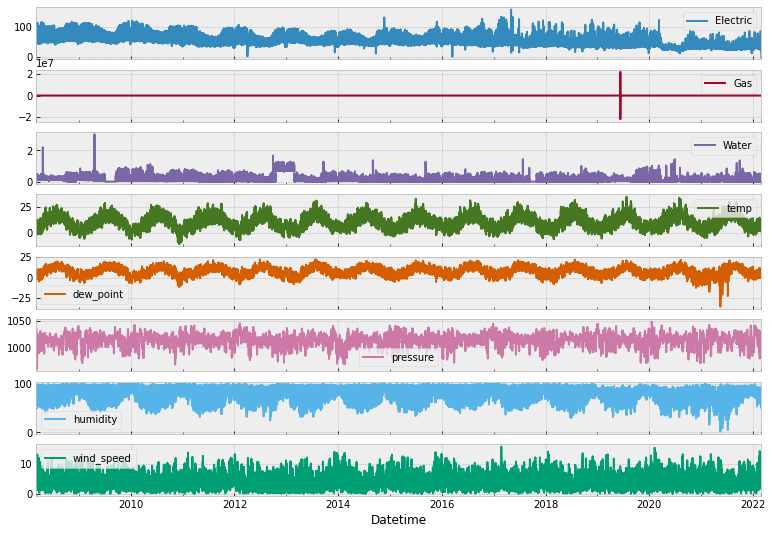

In [60]:
df.plot(subplots=True, figsize=(13,9))

In [61]:
df = df.loc[:'2020-03-15']
data = df.reset_index()

dataset_train = data.copy()

dataset_train

,Datetime,Electric,Gas,Water,temp,dew_point,pressure,humidity,wind_speed
0,2008-03-03 00:00:00,0.00,2.5070,0.1400,6.34,2.97,1009,79,6.72
1,2008-03-03 01:00:00,0.00,2.5070,0.1400,5.50,2.50,1009,81,6.82
2,2008-03-03 02:00:00,0.00,2.5070,0.1410,5.21,1.33,1010,76,6.75
3,2008-03-03 03:00:00,0.00,2.5070,0.1385,4.54,0.13,1010,73,6.58
4,2008-03-03 04:00:00,0.00,354.7950,0.1390,3.84,-0.32,1010,74,6.55
...,...,...,...,...,...,...,...,...,...
105499,2020-03-15 19:00:00,34.75,5.5755,0.0175,5.63,3.48,1009,86,2.94
105500,2020-03-15 20:00:00,33.75,0.0000,0.0550,5.54,3.22,1010,85,3.33
105501,2020-03-15 21:00:00,35.25,0.0000,0.0425,5.61,3.29,1011,85,3.56
105502,2020-03-15 22:00:00,35.00,5.5755,0.0650,4.68,2.38,1012,85,2.75


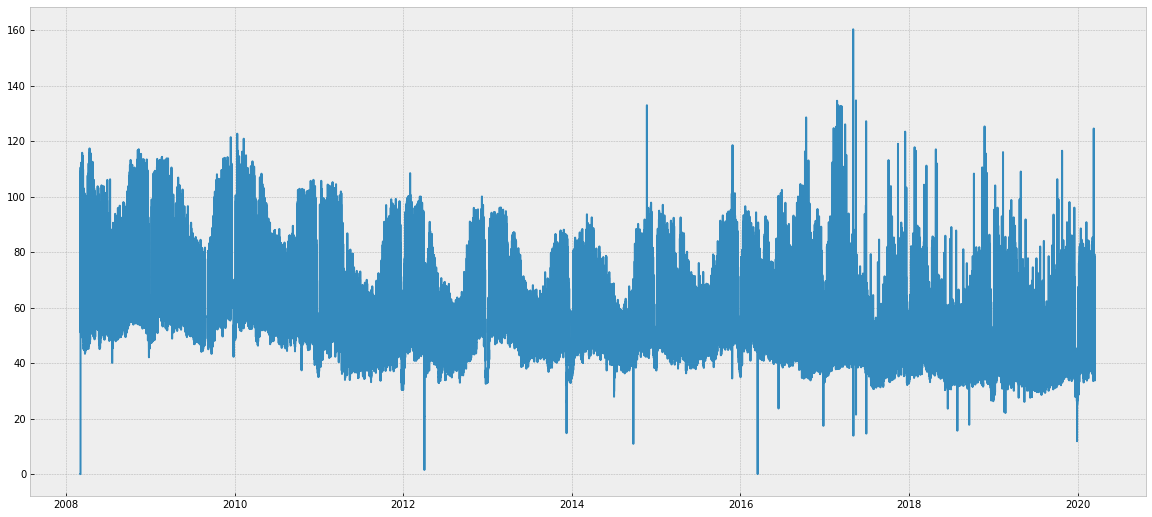

In [62]:
plt.plot(dataset_train['Datetime'], dataset_train['Electric'])

In [63]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Datetime'])
# datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (105504, 9)
All timestamps == 105504
Featured selected: ['Electric', 'Gas', 'Water', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed']


## Step #2. Data pre-processing
Removing all commas and convert data to matrix shape format.

In [64]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set[:1]

Shape of training set == (105504, 8).


array([[0.000e+00, 2.507e+00, 1.400e-01, 6.340e+00, 2.970e+00, 1.009e+03,
        7.900e+01, 6.720e+00]])

In [65]:
# Feature Scaling
from sklearn.preprocessing import *

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.2199688 ],
       [0.21840874],
       [0.22776911]])

In [66]:
# Creating a data structure with 120 timestamps and 1 output
X_train = []
y_train = []

n_future = 18000  # Number of days we want top predict into the future
n_past = 1     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (87504, 1, 7).
y_train shape == (87504, 1).


In [85]:
X_train[:5]

array([[[0.        , 0.49999405, 0.04627334, 0.37412281, 0.42975697,
         0.55555556, 0.72      ]],

       [[0.        , 0.49999405, 0.04627334, 0.35570175, 0.41582691,
         0.55555556, 0.74666667]],

       [[0.        , 0.49999405, 0.04660387, 0.34934211, 0.38114997,
         0.56666667, 0.68      ]],

       [[0.        , 0.49999405, 0.04577756, 0.33464912, 0.34558388,
         0.56666667, 0.64      ]],

       [[0.        , 0.50000213, 0.04594282, 0.31929825, 0.33224659,
         0.56666667, 0.65333333]]])

# PART 2. Create a model. Training
## Step #3. Building the LSTM based Neural Network

In [67]:
# Import Libraries and packages from Keras
from keras.models import *
from keras.layers import *

In [97]:
# Initializing the Neural Network based on LSTM
model = Sequential()
model.add(LSTM(units=150, activation='relu', input_shape=(n_past, dataset_train.shape[1]-1), return_sequences=True))
model.add(LSTM(units=150, activation='relu', return_sequences=True))
model.add(LSTM(units=150, activation='relu', return_sequences=True))
# model.add(LSTM(units=32, activation='relu', return_sequences=True))
# model.add(LSTM(units=32, activation='relu', return_sequences=True))
# model.add(LSTM(units=32, activation='relu', return_sequences=True))
# model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
# model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1))
model.summary()

# model = Sequential()
# model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
# model.add(Bidirectional(LSTM(units=128)))
# model.add(Dropout(rate=0.25))
# model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1, 150)            94800     
                                                                 
 lstm_23 (LSTM)              (None, 1, 150)            180600    
                                                                 
 lstm_24 (LSTM)              (None, 1, 150)            180600    
                                                                 
 lstm_25 (LSTM)              (None, 32)                23424     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 479,457
Trainable params: 479,457
Non-tr

## Step #4. Start training

In [98]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.1, verbose=1)

Epoch 1/100
2457/2462 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 1: val_loss improved from inf to 0.00892, saving model to weights.h5
2462/2462 [==============================] - 23s 7ms/step - loss: 0.0100 - val_loss: 0.0089 - lr: 0.0010
Epoch 2/100
2459/2462 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 2: val_loss improved from 0.00892 to 0.00887, saving model to weights.h5
2462/2462 [==============================] - 17s 7ms/step - loss: 0.0065 - val_loss: 0.0089 - lr: 0.0010
Epoch 3/100
2456/2462 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 3: val_loss improved from 0.00887 to 0.00874, saving model to weights.h5
2462/2462 [==============================] - 15s 6ms/step - loss: 0.0064 - val_loss: 0.0087 - lr: 0.0010
Epoch 4/100
2455/2462 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 4: val_loss improved from 0.00874 to 0.00853, saving model to weights.h5
2462/2462 [==============================] - 14s 6ms/

KeyboardInterrupt: 

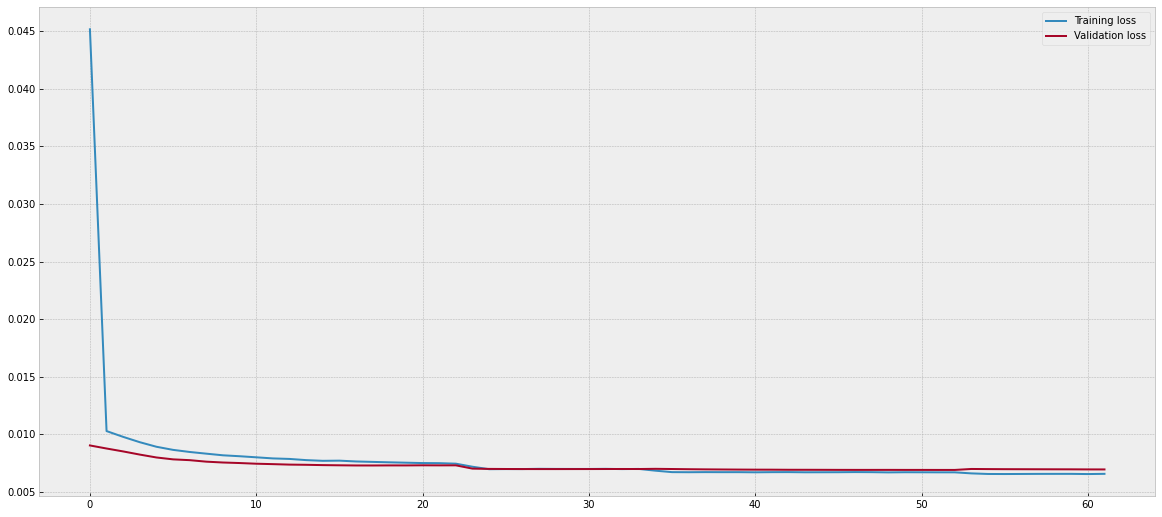

In [88]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

## PART 3. Make future predictions

In [89]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1h').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

## Step #5. Make predictions for future dates

In [90]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

predictions_train1 = model.predict(X_train)

## Step #6. Evaluate Metrics

In [91]:
from sklearn.metrics import *

print('RMSE: ', round(np.sqrt(mean_squared_error(y_train, predictions_train1)),3))
print('MSE: ', round(mean_squared_error(y_train, predictions_train1),3))
print('MAE: ', round(mean_absolute_error(y_train, predictions_train1),3))
print('R2: ', round(r2_score(y_train, predictions_train1),3))

RMSE:  0.079
MSE:  0.006
MAE:  0.06
R2:  0.331


In [92]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['value']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['value']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,value
2010-03-23,44.364361
2010-03-23,44.364361
2010-03-23,44.364529


In [93]:
datelist_train = pd.to_datetime(datelist_train)

In [94]:
dataset_train = dataset_train.set_index(datelist_train)

In [95]:
dataset_train.head()

,Electric,Gas,Water,temp,dew_point,pressure,humidity,wind_speed
2008-03-03 00:00:00,0.0,2.507,0.1400,6.34,2.97,1009.0,79.0,6.72
2008-03-03 01:00:00,0.0,2.507,0.1400,5.50,2.50,1009.0,81.0,6.82
2008-03-03 02:00:00,0.0,2.507,0.1410,5.21,1.33,1010.0,76.0,6.75
2008-03-03 03:00:00,0.0,2.507,0.1385,4.54,0.13,1010.0,73.0,6.58
2008-03-03 04:00:00,0.0,354.795,0.1390,3.84,-0.32,1010.0,74.0,6.55


## Step #6. Visualize the Predictions

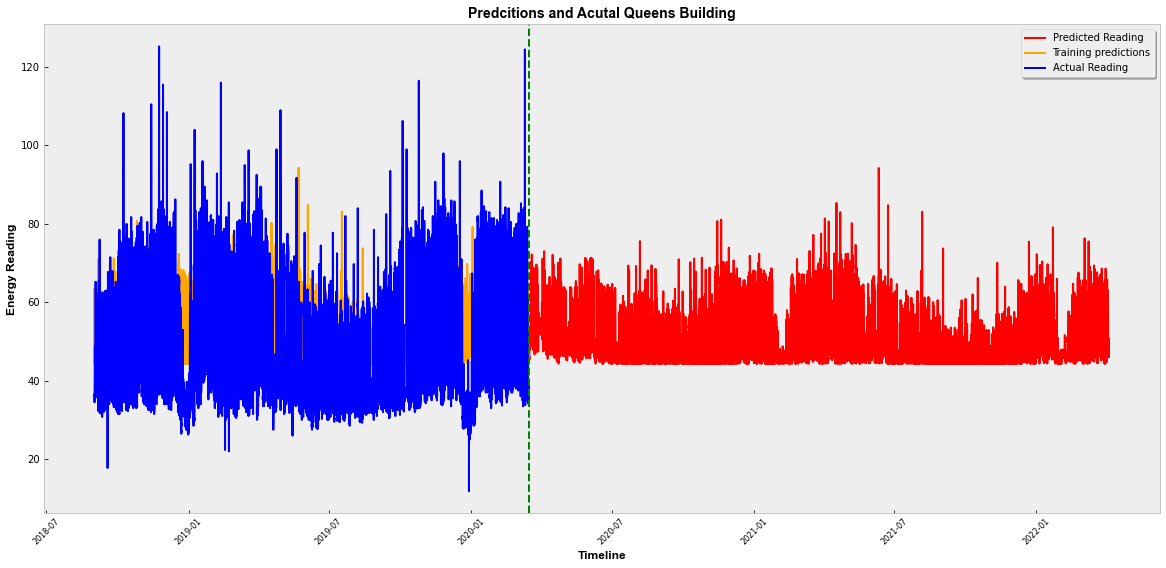

In [96]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 9

# Plot parameters
START_DATE_FOR_PLOTTING = '2018-09'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['value'], color='r', label='Predicted Reading')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['value'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Electric'], color='b', label='Actual Reading')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Queens Building', family='Arial', fontsize=14, fontweight='bold')
plt.xlabel('Timeline', family='Arial', fontsize=12, fontweight='bold')
plt.ylabel('Energy Reading', family='Arial', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=8)
plt.show()